<a href="https://colab.research.google.com/github/alexiamhe93/goldStandard-tutorial/blob/main/Tutorial_3_Deep_learning_BERT_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial 3: Building a deep supervise machine learning classifier using BERT

Authors: Goddard, A. & Gillespie, A.

Date: January 2023

This tutorial provides instructions on how to train and validate a deep supervised machine learning model using a dataset of sentences coded for misunderstandings. The sentences were produced in naturally occuring online dialogues, sourced from Reddit, Twitter, and Wikipedia Talk Pages.

We use the ktrain package (Maiya, 2022) for Python (https://github.com/amaiya/ktrain) to fine-tune a BERT (Devlin et al., 2019) transformer model for classifying sentences as misunderstanding. Using a pre-trained transformer model means we can use a relatively small training dataset to make new predictions.


This tutorial provides instructions on how to:
1. Train a model using ktrain by fine-tuning BERT 
2. Tweak hyper-parameters to improve the classifier's performance
3. Use under-sampling to re-balance an unbalanced dataset
4. Save and load the trained model for use elsewhere

> **NOTE** For the best performance, we recommend changing the Google Colaboratory runtime to a GPU (click *'Runtime'*, *'Change runtime type'* and select *'GPU'*). This will considerably speed up the training process for the classifier.

References: 

Maiya, A.S. (2022). *ktrain: A Low-Code Library for Augmented Machine Learning*. (arXiv:2004.10703). arXiv. https://doi.org/10.48550/arXiv.2004.10703

Devlin, J., Chang, M.-W., Lee, K., & Toutanova, K. (2019). BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding. *Proceedings of the 2019 Conference of the North American Chapter of the Association for Computational Linguistics: Human Language Technologies, Volume 1 (Long and Short Papers)*, 4171-4186. https://doi.org/10.18653/v1/N19-1423


See also: https://colab.research.google.com/drive/1ixOZTKLz4aAa-MtC6dy_sAvc9HujQmHN#scrollTo=Y8hIFvooF4vc, https://medium.com/towards-data-science/bert-text-classification-in-3-lines-of-code-using-keras-264db7e7a358, and: https://towardsdatascience.com/ktrain-a-lightweight-wrapper-for-keras-to-help-train-neural-networks-82851ba889c


# Install packages

> **NOTE** Make sure to run this cell first.

In [ ]:
!pip install ktrain

# Load packages required to train the model

In [3]:
# for downloading data
import requests, zipfile, io
# for mathematical / vectoral operations
import numpy as np
# for loading dataframes and spreadsheets (.csv)
import pandas as pd
# for loading ktrain to train the model
import ktrain
from ktrain import text
# for splitting dataset into train and test
from sklearn.model_selection import train_test_split

# Load and clean data for analysis

This cell downloads the gold standard dataset from github and unzips it.

In [4]:
r = requests.get( 'https://github.com/alexiamhe93/goldStandard-tutorial/blob/main/Data/Tutorial-data.zip?raw=true' ) 
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall()

This cell loads the gold standard dataset into a dataframe.

In [5]:
df0 = pd.read_csv("Tutorial-data/Full_misunderstandings_data.csv")

## Clean text data for analysis

The below cell runs a simple cleaning protocol over the data, selecting only relevant columns for the analysis, renaming columns where appropriate, removing any empty or numeric values in the text column, and deleting any rows which were not coded for 1 or 0 in the misunderstanding column.

In [6]:
# Select relevant columns for analysis
df0 = df0[["turn_id", "dialogue_id", "turn", "text", "Misunderstanding"]]
# delete any rows with no text
df0 = df0[df0["text"] != ""]
# delete all na rows with no text
df0 = df0[df0['text'].notna()]
# delete any numerical rows with no text
df0 = df0[~df0['text'].str.isnumeric()]
# delete all values for misunderstanding not equal to zero or one
df0 = df0[df0["Misunderstanding"].isin([0,1])]
# gives us the number of rows in loaded dataset after the cleaning process
print(f"The full dataset contains {len(df0)} sentences after cleaning.")

The full dataset contains 21982 sentences after cleaning.


The cleaning process resulted in 12 rows removed. We can check the first five rows of the dataset to see if they appear as we expect them to:

In [7]:
# inspect dataframe
df0.head()

,turn_id,dialogue_id,turn,text,Misunderstanding
0,tid_50,group_101723,turn_1,CMV: Territorial integrity should be taken les...,0
1,tid_50,group_101723,turn_1,"However, in my opinion, the insistence on part...",0
2,tid_50,group_101723,turn_1,Take the Western Brownberg as an example.,0
3,tid_50,group_101723,turn_1,An independent state in the region has no prec...,0
4,tid_50,group_101723,turn_1,The basis of such claims is that the Spanish u...,0


# Model 1: classifier using full dataset

This section trains the first model, without yet using undersampling on our dataset to improve its performance. This section also details how to identify the optimal learning-rate, a key hyper-parameter set by the researcher prior to training the model. 

## Split dataset into training and validation datasets

In this section, we randomly split our data into a training dataset (70%) and a validation dataset (30%). The training set is used by the BERT classifier to identify the optimal features from the input text to best predict whether it is a misunderstanding.

We stratify the data so that the frequency of misunderstandings is the same in both datasets. This is especially important for highly imbalanced datasets (such as the present dataset) as we want to ensure enough of of the target variable in the validation set.

In [ ]:
# for splitting dataset into train and test sets
from sklearn.model_selection import train_test_split
# create vectors of texts from loaded dataset
sentences = df0['text'].copy()
# create vector of misunderstanding codes from loaded dataset
misunderstanding_codes = df0['Misunderstanding'].astype(int).copy()

# Split dataset
training_sentences, validation_sentences, training_codes, validation_codes = train_test_split(sentences, # text vector
                                                                                              misunderstanding_codes, # codes vector
                                                                                              test_size=0.30, # size of validation set (30%)
                                                                                              random_state=10, # random seed for replicating random split
                                                                                              stratify=misunderstanding_codes) # stratification by the codes vector

# Create train dataframe, ensuring codes are integers for the ktrain.text function
Training_df = pd.DataFrame({"text": training_sentences, "Misunderstanding": [int(x) for x in training_codes]})
# Create validation dataframe, ensuring codes are integers for the ktrain.text function
Validation_df = pd.DataFrame({"text": validation_sentences, "Misunderstanding": [int(x) for x in validation_codes]})

## Pre-process the text for use with the BERT classifier

The BERT model expects the text to be preprocessed in a specific way (see Devlin et al., 2019). This can be done in the ktrain package using the `text.texts_from_df()` function. This function also lets us set the maximum number of words in a text considered by the model (`maxlen`) and the maximum number of features derived for BERT's neural network (`max_features`). 

The function outputs five files. Four vectors relating to the training and validation datasets (where `x` refers to the texts and `y` refers to the codes from the gold-standard dataset) and a preprocessing file denoted `preproc`. 

In [ ]:
# Create objects ready for ktrain learner object (train/test sets + preprocessing object)
(x_train,  y_train), (x_validation, y_validation), preproc = text.texts_from_df(train_df = Training_df, # training df
                                                                            text_column = "text", # text column for both training and validation dataframe
                                                                            label_columns = ["Misunderstanding"], # column for the codes being predicted
                                                                            val_df = Validation_df, # validation df
                                                                            preprocess_mode='bert', # preprocessing mode for feature embeddings - Google's BERT
                                                                            maxlen=64, # this is the max number of words for a document
                                                                            max_features=50000) # size of network


['not_Misunderstanding', 'Misunderstanding']
       not_Misunderstanding  Misunderstanding
20550                   0.0               1.0
15650                   1.0               0.0
5664                    1.0               0.0
12922                   1.0               0.0
14970                   1.0               0.0
['not_Misunderstanding', 'Misunderstanding']
       not_Misunderstanding  Misunderstanding
8557                    1.0               0.0
14465                   1.0               0.0
11540                   1.0               0.0
461                     0.0               1.0
21202                   1.0               0.0
downloading pretrained BERT model (uncased_L-12_H-768_A-12.zip)...
[██████████████████████████████████████████████████]
extracting pretrained BERT model...
done.

cleanup downloaded zip...
done.

preprocessing train...
language: en


Is Multi-Label? False
preprocessing test...
language: en


## Prime the model using ktrain. 

The below cell defines the model used by ktrain, which is a BERT classifier using the preprocessing instructions provided in the previous cell.

In [ ]:
model = text.text_classifier('bert', train_data=(x_train, y_train), preproc=preproc)

Is Multi-Label? False
maxlen is 64
done.


## Create the learner object
The below cell sets the learner object. The learner object is what will be continually updated during the training process and will define the features for our final classifier. This is also where we set the `batch_size` hyper-parameter, which refers to the number of coded texts observed by the algorithm before it refines its features. The original BERT paper recommends a batch size of 16 or 32 (Devlin et al., 2019). Accordingly, we set the batch size to 16.

In [ ]:
learner = ktrain.get_learner(model, train_data=(x_train, y_train), batch_size=16)

## Find optimal learning rate

Before training the classifier, it may be beneficial to identify the optimal learning rate. The learning rate refers to the size of the steps the algorithm uses to identify local minima using gradient-descent. The original BERT paper recommends a learning rate of 5e-5, 3e-5, or 2e-5.

The following function simulates the classifier's training, increasing the learning rate iteratively, and estimating the learning loss. The learning loss is an estimate of discrepancies between the model's predicted scores and the gold-standard scores.

In [ ]:
learner.lr_find(max_epochs = 20) 

simulating training for different learning rates... this may take a few moments...
Epoch 1/20
962/962 [==============================] - 248s 237ms/step - loss: 0.6067 - accuracy: 0.6075
Epoch 2/20
962/962 [==============================] - 227s 236ms/step - loss: 0.2572 - accuracy: 0.9218
Epoch 3/20
962/962 [==============================] - 227s 236ms/step - loss: 0.2074 - accuracy: 0.9252
Epoch 4/20
962/962 [==============================] - 227s 236ms/step - loss: 0.1623 - accuracy: 0.9379
Epoch 5/20
962/962 [==============================] - 227s 236ms/step - loss: 0.1328 - accuracy: 0.9462
Epoch 6/20
962/962 [==============================] - 227s 236ms/step - loss: 0.1039 - accuracy: 0.9596
Epoch 7/20
962/962 [==============================] - 227s 236ms/step - loss: 0.0917 - accuracy: 0.9644
Epoch 8/20
962/962 [==============================] - 227s 236ms/step - loss: 0.1323 - accuracy: 0.9541
Epoch 9/20
962/962 [==============================] - 24s 25ms/step - loss: 0.2849 - 

The next function plots the results of the previous cell's function, where we observe that the loss decreases from a learning rate of e-7 to 5e-5, but then begins increasing for learning rates above e-4. This suggests an optimal learning rate is within the range of learning rates suggested for BERT. 

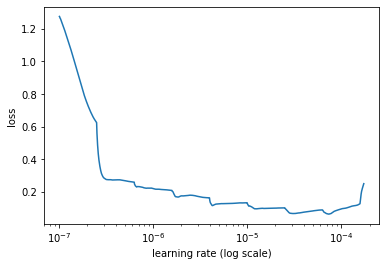

In [ ]:
learner.lr_plot()

## Train model

The below function trains the new classifier. It takes as inputs the number of epochs, which refers to the number of times the algorithm observes the entire training set, and the learning rate. The original BERT paper recommends 2,3, or 4 epochs (Devlin et al., 2019) as optimal for fine-tuning BERT. We set our first model with 4 epochs and a learning rate of 2e-5.

We also use a '1cycle' approach for training the classifier, a method for optimizing how the algorithm uses the learning rate during training (see Smith, 2018 for details).   

References:

Smith, L. N. (2018). *A disciplined approach to neural network hyper-parameters: Part 1--learning rate, batch size, momentum, and weight decay*. arXiv preprint arXiv:1803.09820.


In [ ]:
learner.fit_onecycle(2e-5, 4)



begin training using onecycle policy with max lr of 2e-05...
Epoch 1/4
962/962 [==============================] - 250s 238ms/step - loss: 0.2202 - accuracy: 0.9093
Epoch 2/4
962/962 [==============================] - 228s 237ms/step - loss: 0.1350 - accuracy: 0.9460
Epoch 3/4
962/962 [==============================] - 228s 237ms/step - loss: 0.0695 - accuracy: 0.9726
Epoch 4/4
962/962 [==============================] - 228s 237ms/step - loss: 0.0165 - accuracy: 0.9950


## Validate model

To check the model's accuracy, we generate a classification report with four accuracy statistics based on the true/false positives and negatives for the classifier. A true positive is where the predicted code equals 1 and the gold-standard code equals 1; a true negative is where the predicted code equals 0 and the gold-standard code equals 0; a false positive is where the predicted code equals 0 but the gold-standard code equals 1; and, finally, a false negative is where the predicted code equals 1 but the gold-standard code equals 0. The four basic accuracy statistics are:

*   Accuracy: the ratio of correct predictions 
*   Precision: the ratio of true positives to true positives and false positives
*   Recall: the ratio of true positives to true positives and false negatives
*   F1 score: harmonic mean of precision and recall

In [ ]:
learner.validate(val_data=(x_validation, y_validation))

207/207 [==============================] - 35s 146ms/step
              precision    recall  f1-score   support

           0       0.96      0.97      0.97      6080
           1       0.64      0.56      0.60       515

    accuracy                           0.94      6595
   macro avg       0.80      0.77      0.78      6595
weighted avg       0.94      0.94      0.94      6595



array([[5915,  165],
       [ 225,  290]])

Our model performs fairly poorly (F1-score = 0.60), with moderate precision (0.64) but weak recall (0.56). The accuracy is inflated (0.94) due to the number of no misunderstandings in the dataset, meaning that the classifier can perform relatively well only classifying data into this class. 

# Model 2: undersampling to increase model performance

In this section, we train a new model with the same hyper-parameters (batch size, number of epochs, and learning rate), but rebalance our dataset using undersampling.

Our dataset is highly skewed towards no misunderstandings:


In [ ]:
pct_mis = round(len(df0[df0["Misunderstanding"]==1])/len(df0) *100)
print(f"Percentage of sentences that are misunderstandings {pct_mis}%\nPercentage of sentences that are not misunderstandings: {100-pct_mis}%")

Percentage of sentences that are misunderstandings 8
Percentage of sentences that are not misunderstandings: 92


Undersampling is the process of randomly deleting example texts from the majority class in order to re-balance the dataset. Researchers may also use oversampling, which involves randomly re-sampling cases of the minority class (i.e. misunderstandings) to balance the data. We chose undersampling as, even though we lose discriminating information (see Susan & Kumar, 2021), we reduce the chance of overfitting to the training data due to the limited number of misunderstandings. 

We also remove any noisey codes in the gold-standard dataset by deleting any duplicate texts. This removes any texts that potentially have contradicting codes (e.g. a sentence coded for misunderstanding in one instance and no misunderstanding in another instance).

After a number of different models, we found a 2:1 no misunderstandings to misunderstandings ratio provided the optimal undersampling for our classifier. 

In [ ]:
# Remove any duplicate text files - this prevents any ambiguously coded rows
df1 = df0.drop_duplicates("text")
print(f"Number of texts with duplicates {len(df0)}\nNumber of texts without duplicates {len(df1)}\nRows removed: {len(df0)-len(df1)}")

Number of texts with duplicates 21982
Number of texts without duplicates 20984
Rows removed: 998


In [ ]:
# select misunderstanding turns
mis_df1 = df1[df1["Misunderstanding"]==1]
# select non-misunderstanding turns; stating the random state ensures reproducibility
notmis_df1 = df1[df1["Misunderstanding"]==0].sample(2*len(mis_df1), random_state=10) 
# create new undersampling dataframe
df2 = pd.concat([mis_df1, notmis_df1])

The dataset is now much smaller, but considerably more balanced:

In [ ]:
print(f"New dataframe size {len(df2)}\nRows removed from original dataset: {len(df0)-len(df2)}")
pct_mis2 = round(len(df2[df2["Misunderstanding"]==1])/len(df2) *100)
print(f"Percentage of sentences that are misunderstandings {pct_mis2}%\nPercentage of sentences that are not misunderstandings: {100-pct_mis2}%")

New dataframe size 5073
Rows removed from original dataset: 16909
Percentage of sentences that are misunderstandings 33%
Percentage of sentences that are not misunderstandings: 67%


## Create new training and vaidation dataset & preprocess

In [ ]:
# create vectors of texts from loaded dataset
sentences2 = df2['text'].copy()
# create vector of misunderstanding codes from loaded dataset
misunderstanding_codes2 = df2['Misunderstanding'].astype(int).copy()

# Split dataset
training_sentences2, validation_sentences2, training_codes2, validation_codes2 = train_test_split(sentences2, # text vector
                                                                                              misunderstanding_codes2, # codes vector
                                                                                              test_size=0.30, # size of validation set (30%)
                                                                                              random_state=10, # random seed for replicating random split
                                                                                              stratify=misunderstanding_codes2) # stratification by the codes vector

# Create train dataframe, ensuring codes are integers for the ktrain.text function
Training_df2 = pd.DataFrame({"text": training_sentences2, "Misunderstanding": [int(x) for x in training_codes2]})
# Create validation dataframe, ensuring codes are integers for the ktrain.text function
Validation_df2 = pd.DataFrame({"text": validation_sentences2, "Misunderstanding": [int(x) for x in validation_codes2]})

# Create objects ready for ktrain learner object (train/test sets + preprocessing object)
(x_train2,  y_train2), (x_validation2, y_validation2), preproc2 = text.texts_from_df(train_df = Training_df2, # training df
                                                                            text_column = "text", # text column for both training and validation dataframe
                                                                            label_columns = ["Misunderstanding"], # column for the codes being predicted
                                                                            val_df = Validation_df2, # validation df
                                                                            preprocess_mode='bert', # preprocessing mode for feature embeddings - Google's BERT
                                                                            maxlen=64, # this is the max number of words for a document
                                                                            max_features=50000) # size of network

['not_Misunderstanding', 'Misunderstanding']
       not_Misunderstanding  Misunderstanding
11985                   1.0               0.0
15974                   0.0               1.0
10561                   1.0               0.0
14079                   1.0               0.0
4781                    1.0               0.0
['not_Misunderstanding', 'Misunderstanding']
       not_Misunderstanding  Misunderstanding
2205                    1.0               0.0
1521                    1.0               0.0
15841                   1.0               0.0
12437                   1.0               0.0
9960                    1.0               0.0
preprocessing train...
language: en


Is Multi-Label? False
preprocessing test...
language: en


## Train Model 2 using undersampled data

In [ ]:
model = text.text_classifier('bert', train_data=(x_train2, y_train2), preproc=preproc2)
learner = ktrain.get_learner(model, train_data=(x_train2, y_train2), batch_size=16)

Is Multi-Label? False
maxlen is 64
done.


In [ ]:
learner.fit_onecycle(2e-5, 4)



begin training using onecycle policy with max lr of 2e-05...
Epoch 1/4
222/222 [==============================] - 70s 221ms/step - loss: 0.5034 - accuracy: 0.7482
Epoch 2/4
222/222 [==============================] - 51s 231ms/step - loss: 0.3287 - accuracy: 0.8643
Epoch 3/4
222/222 [==============================] - 51s 230ms/step - loss: 0.1898 - accuracy: 0.9259
Epoch 4/4
222/222 [==============================] - 51s 231ms/step - loss: 0.0615 - accuracy: 0.9809


## Validate model 2

In [ ]:
learner.validate(val_data=(x_validation2, y_validation2))

48/48 [==============================] - 11s 141ms/step
              precision    recall  f1-score   support

           0       0.90      0.92      0.91      1015
           1       0.82      0.79      0.81       507

    accuracy                           0.87      1522
   macro avg       0.86      0.85      0.86      1522
weighted avg       0.87      0.87      0.87      1522



array([[929,  86],
       [106, 401]])

Model 2 performs much better than Model 1 (F1-score = 0.81), with a slightly higher precision (0.82) than recall (0.79). This suggests that are classifier is marginally better at correctly predicting a sentence as a misunderstanding (identifying true positives) than identifying all instances of misunderstanding (identifying true negatives).

# Predict new data using Model 2

Now that we have a trained model, we can sense-check it by predicting whether sentences we suggest are misunderstandings or not. The next cell shows how to load the predictor using a simple `Predictor.predict()` function based on the BERT classifier we have just fine-tuned.

In [ ]:
# create a predictor tool
Predictor = ktrain.get_predictor(learner.model, preproc2)
# check the classes are correct
Predictor.predict("I don't understand you.")

1/1 [==============================] - 0s 39ms/step


'Misunderstanding'

> **NOTE** The next cells can be used to save the model to disk and recalling it for future use. 

In [ ]:
# saves model to disk
ktrain.get_predictor(model, preproc2).save('trained_models/mis_model_5')
# reloads model into the notebook
Predictor = ktrain.load_predictor('trained_models/mis_model_5')

We now create a set of 15 sentences to sense-check the new prediction tool to see if it passes a face-validity check. The 15 sentences include five sentences we would classify as misunderstanding, five we would classify as not misunderstanding, and five edge cases that skew slightly to either misunderstanding or not. 

In [ ]:
# Create list of sentences, 5 misunderstandings, 5 non misunderstandings, and 5 edge cases
user_generated_sentences = ["That's not what I meant", "I don't get your point", 
                            "I said this above, PLEASE try to read my points",
                            "What do you mean?", "That's not what I meant.",
                            "My favourite shoes are Nikes","My least favourite thing to do is watch TV",
                            "It's really cold outside.", "I know how you feel.", "I get it.",
                            "I get that, but why bother?", 
                            "I understand your point on cats, but what is your stance on dogs?",
                            "I'm glad we've not misunderstood each other.", 
                            "So I said to him, 'I don't get it', but I actually did understand",
                            "Don't get me wrong, I love cats."]
# List of the true codes decided by researcher
true_codes = ["Misunderstanding", "Misunderstanding", "Misunderstanding", 
              "Misunderstanding", "Misunderstanding", "Not misunderstanding",
              "Not misunderstanding","Not misunderstanding","Not misunderstanding",
              "Not misunderstanding","Misunderstanding (edge case)", 
              "Misunderstanding (edge case)", "Not Misunderstanding (edge case)", 
              "Not Misunderstanding (edge case)", "Not Misunderstanding (edge case)"]

# Run the predictor on the user generated sentences
predicted_codes = [Predictor.predict(s) for s in user_generated_sentences]


1/1 [==============================] - 0s 33ms/step


In [ ]:
# Display the results as a dataframe

pd.DataFrame({"User sentences": user_generated_sentences,
              "True codes": true_codes, "Classifier codes": predicted_codes})

,User sentences,True codes,Classifier codes
0,That's not what I meant,Misunderstanding,Misunderstanding
1,I don't get your point,Misunderstanding,Misunderstanding
2,"I said this above, PLEASE try to read my points",Misunderstanding,Misunderstanding
3,What do you mean?,Misunderstanding,Misunderstanding
4,That's not what I meant.,Misunderstanding,Misunderstanding
5,My favourite shoes are Nikes,Not misunderstanding,not_Misunderstanding
6,My least favourite thing to do is watch TV,Not misunderstanding,not_Misunderstanding
7,It's really cold outside.,Not misunderstanding,not_Misunderstanding
8,I know how you feel.,Not misunderstanding,not_Misunderstanding
9,I get it.,Not misunderstanding,not_Misunderstanding


We observe that for the ten examples we consider clear misunderstanding or clear non misunderstandings, the classifier performs as expected, classifying all ten into the correct class. However, for the edge cases (sentences 10-14), the classifier incorrectly classifies 2/5 sentences. The following paragraph explains the edge cases and how the algorithm succeeds and fails to differentiate between them.

Sentences 10 and 11 are examples of misunderstandings following a statement of misunderstanding in the same sentence. Here, the classifier correctly predicts the construct. Sentence 12 is a statement that two interacting individuals have not misunderstood each other. The classifier incorrectly classifies this as a misunderstanding. Sentence 13 is a quoted statement of misunderstanding, with the imagined speaker saying they were actually lying about misunderstanding. Again, the classifier fails to correctly identify this statement as not a misunderstanding. Finally, sentence 14 is hedging ("don't get me wrong") by clarifying the meaning of their next or previous sentences. Here, the classifier correctly identifies this as not misunderstanding. 

# Conclusion

In this tutorial, we provided instructions on how to fine-tune a BERT classifier for predicting misunderstandings, a social-psychological construct, in sentences sampled from online dialogues. Our final classifier (Model 2) performs moderately well (F1-score = 0.81), but, following a sense-check for face-validity, was found to struggle with edge-cases of the phenomena. This may be in part from noise in the gold-standard dataset used, which had moderate inter-rater reliability (Krippendorf's Alpha = 0.80). This means that certain misunderstandings in the gold-standard dataset may have been missed or incorrectly coded in the first instance. The trained classifier is only as good as the gold-standard dataset used to train it.

The tutorial is limited in its demonstration of a binary classifier, however ktrain and BERT can both handle multi-label categorical classes. Furthermore, the tutorial makes an assumption that the sentences in the dataset are independent which they are not. Instead, sentences belong to a larger text (e.g. a comment on Reddit or a Tweet) and to a dialogue. This added sequential information is ignored in the training of the classifier but its inclusion in future models may lead to increased accuracy and better reflect the gold-standard codes from the dataset.